# GitOps Flow with MLRun

## 1. Development and Deployment Flow 

![](docs/mlrun_function.png)

![](docs/mlrun_project.png)

## 2. Basic Training and Serving

In [23]:
import os
from src import create_and_set_project

project = create_and_set_project(
    name="gitops-flow-v2",
    env_file="config.env",
    git_source="v3io:///bigdata/gitops.zip"
)

> 2023-09-15 21:54:26,748 [info] Server and client versions are not the same but compatible: {'parsed_server_version': VersionInfo(major=1, minor=4, patch=1, prerelease=None, build=None), 'parsed_client_version': VersionInfo(major=1, minor=3, patch=0, prerelease=None, build=None)}
> 2023-09-15 21:54:26,787 [info] loaded project gitops-flow-v2 from MLRun DB


### Train Model with Auto-Logging

In [2]:
%%writefile ./src/functions/basic_train.py

import mlrun
import pandas as pd
from mlrun.frameworks.sklearn import apply_mlrun
from sklearn import ensemble
from sklearn.model_selection import train_test_split


@mlrun.handler()
def train_model(context, dataset: pd.DataFrame, label_column: str):
    # Initialize our dataframes
    X = dataset.drop(label_column, axis=1)
    y = dataset[label_column]

    # Train/Test split Iris data-set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Pick an ideal ML model
    model = ensemble.RandomForestClassifier()

    # Wrap our model with Mlrun features, specify the test dataset for analysis and accuracy measurements
    #######################################################################
    apply_mlrun(model, model_name="my_model", x_test=X_test, y_test=y_test)
    #######################################################################

    # Train our model
    model.fit(X_train, y_train)


Overwriting ./src/functions/basic_train.py


In [3]:
train_fn = project.set_function(
    name='basic-train',
    func='src/functions/basic_train.py',
    kind='job',
    image='mlrun/mlrun',
    handler="train_model"
)

In [4]:
training_run = project.run_function(
    train_fn,
    inputs={
        "dataset" : "https://s3.wasabisys.com/iguazio/data/model-monitoring/iris_dataset.csv",
        "label_column" : "label"
    }
)

> 2023-09-15 21:48:38,525 [info] Storing function: {'name': 'basic-train-train-model', 'uid': '37e47e10d3044ef89341294aab031619', 'db': 'http://mlrun-api:8080'}
> 2023-09-15 21:48:38,817 [info] Job is running in the background, pod: basic-train-train-model-rrd89
> 2023-09-15 21:48:42,646 [info] Server and client versions are not the same but compatible: {'parsed_server_version': VersionInfo(major=1, minor=4, patch=1, prerelease=None, build=None), 'parsed_client_version': VersionInfo(major=1, minor=3, patch=0, prerelease=None, build=None)}
> 2023-09-15 21:48:45,548 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 37e47e10d3044ef89341294aab031619 -p gitops-flow-v2', 'logs_cmd': 'mlrun logs 37e47e10d3044ef89341294aab031619 -p gitops-flow-v2'}
> 2023-09-15 21:48:45,548 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.us-tmp-353.iguazio-cd2.com/mlprojects/gitops-flow-v2/jobs/monitor/37e47e10d3044ef89341294aab031619/overview'}
> 2023-09-15 21:48:45,549

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
gitops-flow-v2,...ab031619,0,Sep 15 21:48:42,completed,basic-train-train-model,v3io_user=nickkind=jobowner=nickmlrun/client_version=1.3.0mlrun/client_python_version=3.9.16host=basic-train-train-model-rrd89,datasetlabel_column,,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0,feature-importancetest_setconfusion-matrixroc-curvesmodel


> 2023-09-15 21:48:48,946 [info] run executed, status=completed: {'name': 'basic-train-train-model'}


In [5]:
training_run.outputs

{'accuracy': 1.0,
 'f1_score': 1.0,
 'precision_score': 1.0,
 'recall_score': 1.0,
 'auc-micro': 1.0,
 'auc-macro': 1.0,
 'auc-weighted': 1.0,
 'feature-importance': 'v3io:///projects/gitops-flow-v2/artifacts/basic-train-train-model/0/feature-importance.html',
 'test_set': 'store://artifacts/gitops-flow-v2/basic-train-train-model_test_set:37e47e10d3044ef89341294aab031619',
 'confusion-matrix': 'v3io:///projects/gitops-flow-v2/artifacts/basic-train-train-model/0/confusion-matrix.html',
 'roc-curves': 'v3io:///projects/gitops-flow-v2/artifacts/basic-train-train-model/0/roc-curves.html',
 'model': 'store://artifacts/gitops-flow-v2/my_model:37e47e10d3044ef89341294aab031619'}

### Deploy Model with Explainability

In [6]:
%%writefile src/functions/shap_serve.py

import mlrun

from cloudpickle import load
from typing import List
import numpy as np
import shap

class ClassifierModelSHAP(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))
        self.explainer = shap.TreeExplainer(self.model)

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
    
    def explain(self, body: dict) -> List:
        """Generate model explaination from sample"""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        shap_values = self.explainer.shap_values(feats)
        return shap_values[result.argmax()].tolist()

Overwriting src/functions/shap_serve.py


In [7]:
custom_serve = project.set_function(
    name='custom-serve',
    func='src/functions/shap_serve.py',
    kind='serving',
    image='mlrun/mlrun',
    requirements=["shap==0.40.0"]
)

In [8]:
custom_serve.add_model(key="model", model_path=training_run.outputs["model"], class_name="ClassifierModelSHAP")

In [9]:
custom_serve.with_requests(mem="1G", cpu=0.1)
custom_serve.with_limits(mem="2G", cpu=0.2)

In [10]:
project.deploy_function(custom_serve)

> 2023-09-15 21:49:00,596 [info] Starting remote function deploy
2023-09-15 21:49:00  (info) Deploying function
2023-09-15 21:49:00  (info) Building
2023-09-15 21:49:01  (info) Staging files and preparing base images
2023-09-15 21:49:01  (info) Building processor image
2023-09-15 21:49:41  (info) Build complete
2023-09-15 21:50:09  (info) Function deploy complete
> 2023-09-15 21:50:11,628 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-gitops-flow-v2-custom-serve.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['gitops-flow-v2-custom-serve-gitops-flow-v2.default-tenant.app.us-tmp-353.iguazio-cd2.com/']}


DeployStatus(state=ready, outputs={'endpoint': 'http://gitops-flow-v2-custom-serve-gitops-flow-v2.default-tenant.app.us-tmp-353.iguazio-cd2.com/', 'name': 'gitops-flow-v2-custom-serve'})

In [11]:
custom_serve.invoke(path="/v2/models/model/predict", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-09-15 21:50:11,707 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-v2-custom-serve.default-tenant.svc.cluster.local:8080/v2/models/model/predict'}


{'id': 'cd3eaeea-e490-48ef-a86f-4b4bf6535c30',
 'model_name': 'model',
 'outputs': [0]}

In [24]:
custom_serve.invoke(path="/v2/models/model/explain", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-09-15 21:54:32,447 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-v2-custom-serve.default-tenant.svc.cluster.local:8080/v2/models/model/explain'}


{'id': 'f9979540-7fc1-4823-a0a9-66ab80616c76',
 'model_name': 'model',
 'outputs': [[0.04511587945560286,
   0.016789883032646485,
   0.3345114940195596,
   0.2679160768255245]]}

## 3. Operational Pipeline

### Feature Store Ingestion (Optional)

In [13]:
import mlrun
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import MapValues, OneHotEncoder
from mlrun.datastore.sources import ParquetSource, DataFrameSource, CSVSource
import pandas as pd
import os
import yaml
import psycopg2
from sqlalchemy.engine import create_engine
from mlrun.datastore.targets import ParquetTarget

data_path = "data"

#### Ingest from local parquet file

In [14]:
heart_disease_target_set = fstore.FeatureSet(
    name="heart_disease_target",
    entities=[fstore.Entity("patient_id")]
)

resp = fstore.ingest(
    featureset=heart_disease_target_set,
    source=ParquetSource(path=f"{data_path}/heart_disease_target.parquet")
)

#### Ingest from External DB (PostgreSQL)

In [15]:
engine = create_engine(os.getenv("POSTGRESQL_DB"))
postgresql_df = pd.read_sql('select * from heart_disease_continuous', engine)

heart_disease_continuous_set = fstore.FeatureSet(
    name="heart_disease_continuous",
    entities=[fstore.Entity("patient_id")]
)

resp = fstore.ingest(
    featureset=heart_disease_continuous_set,
    source=DataFrameSource(df=postgresql_df)
)

#### Ingest CSV from S3 with data transformations

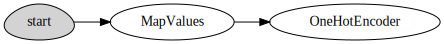

In [16]:
heart_disease_categorical = fstore.FeatureSet(
    name="heart_disease_categorical",
    entities=[fstore.Entity("patient_id")]
)

age_mapping = {'age': {'ranges': {'toddler': [0, 3], 'child': [3, 18], 'adult': [18, 65], 'elder': [65, 120]}}}

one_hot_encoder_mapping = {'age_mapped': ['toddler', 'child', 'adult', 'elder'],
                           'sex': ['male', 'female'],
                           'cp': ['typical_angina', 'atypical_angina', 'non_anginal_pain', 'asymtomatic'],
                           'exang': ['no', 'yes'],
                           'fbs': [False, True],
                           'slope': ['downsloping', 'upsloping', 'flat'],
                           'thal': ['normal', 'reversable_defect', 'fixed_defect']}

heart_disease_categorical.graph.to(MapValues(mapping=age_mapping, with_original_features=True))\
                               .to(OneHotEncoder(mapping=one_hot_encoder_mapping))

display(heart_disease_categorical.plot(rankdir='LR', with_targets=True))

resp = fstore.ingest(
    featureset=heart_disease_categorical,
    source=CSVSource(path="s3://igz-us-sales/heart/heart_disease_categorical.csv")
)

#### Create Feature Vector

In [17]:
vector = fstore.FeatureVector(
    name="heart-disease-vec",
    features=[
        "heart_disease_categorical.*",
        "heart_disease_continuous.*"
    ],
    label_feature="heart_disease_target.target",
    with_indexes=True
)
vector.save()

uri = vector.uri
uri

'store://feature-vectors/gitops-flow-v2/heart-disease-vec'

#### Use Feature Vector for Offline Training

In [18]:
fstore.get_offline_features(feature_vector=uri, target=ParquetTarget()).to_dataframe().head()

> 2023-09-15 21:51:15,525 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/gitops-flow-v2/FeatureStore/heart-disease-vec/parquet/vectors/heart-disease-vec-latest.parquet', 'status': 'ready', 'updated': '2023-09-15T21:51:15.525917+00:00', 'size': 66258, 'partitioned': True}


,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,age,sex_male,sex_female,cp_typical_angina,cp_atypical_angina,cp_non_anginal_pain,...,thal_normal,thal_reversable_defect,thal_fixed_defect,trestbps,chol,restecg,thalach,oldpeak,ca,target
patient_id,,,,,,,,,,,,,,,,,,,,,
e443544b-8d9e-4f6c-9623-e24b6139aae0,0,0,1,0,52,1,0,1,0,0,...,1,0,0,125,212,1,168,1.0,2.0,0
8227d3df-16ab-4452-8ea5-99472362d982,0,0,1,0,53,1,0,1,0,0,...,1,0,0,140,203,0,155,3.1,0.0,0
10c4b4ba-ab40-44de-8aba-6bdb062192c4,0,0,0,1,70,1,0,1,0,0,...,1,0,0,145,174,1,125,2.6,0.0,0
f0acdc22-7ee6-4817-a671-e136211bc0a6,0,0,1,0,61,1,0,1,0,0,...,1,0,0,148,203,1,161,0.0,1.0,0
2d6b3bca-4841-4618-9a8c-ca902010b009,0,0,1,0,62,0,1,1,0,0,...,0,1,0,138,294,1,106,1.9,3.0,0


#### Online Feature Vector for Real-Time Inference

In [19]:
feature_service = fstore.get_online_feature_service(uri)

In [20]:
feature_service.get(
    [
        {"patient_id" : "e443544b-8d9e-4f6c-9623-e24b6139aae0"},
        {"patient_id" : "8227d3df-16ab-4452-8ea5-99472362d982"}
    ]
)

[{'patient_id': 'e443544b-8d9e-4f6c-9623-e24b6139aae0',
  'age_mapped_toddler': 0,
  'age_mapped_child': 0,
  'age_mapped_adult': 1,
  'age_mapped_elder': 0,
  'age': 52,
  'sex_male': 1,
  'sex_female': 0,
  'cp_typical_angina': 1,
  'cp_atypical_angina': 0,
  'cp_non_anginal_pain': 0,
  'cp_asymtomatic': 0,
  'exang_no': 1,
  'exang_yes': 0,
  'fbs_False': 1,
  'fbs_True': 0,
  'slope_downsloping': 1,
  'slope_upsloping': 0,
  'slope_flat': 0,
  'thal_normal': 1,
  'thal_reversable_defect': 0,
  'thal_fixed_defect': 0,
  'trestbps': 125,
  'chol': 212,
  'restecg': 1,
  'thalach': 168,
  'oldpeak': 1.0,
  'ca': 2.0},
 {'patient_id': '8227d3df-16ab-4452-8ea5-99472362d982',
  'age_mapped_toddler': 0,
  'age_mapped_child': 0,
  'age_mapped_adult': 1,
  'age_mapped_elder': 0,
  'age': 53,
  'sex_male': 1,
  'sex_female': 0,
  'cp_typical_angina': 1,
  'cp_atypical_angina': 0,
  'cp_non_anginal_pain': 0,
  'cp_asymtomatic': 0,
  'exang_no': 0,
  'exang_yes': 1,
  'fbs_False': 0,
  'fbs_Tr

### Run Training Pipeline

In [25]:
arguments = {
    "source_url" : uri,
    "label_column" : "target"
}
arguments

{'source_url': 'store://feature-vectors/gitops-flow-v2/heart-disease-vec',
 'label_column': 'target'}

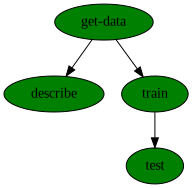

uid,start,state,name,parameters,results
...eebedbe9,Sep 15 21:55:57,completed,test,label_column=targetnew_model_path=store://artifacts/gitops-flow-v2/model:b0abf28b-f41d-4abd-8b7d-5df030cc1181existing_model_path=Nonecomparison_metric=accuracypost_github=Trueforce_deploy=False,accuracy-new_model=1.0test-error-new_model=0.0f1-new_model=1.0precision-new_model=1.0recall-new_model=1.0
...3e12163e,Sep 15 21:55:20,completed,train,label_column=targettest_size=0.1,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0
...02e5c0d6,Sep 15 21:55:20,completed,describe,label_column=target,
...fa8c9787,Sep 15 21:54:49,completed,get-data,,num_rows=968


In [26]:
run_id = project.run(
    name="train",
    arguments=arguments,
    dirty=True,
    watch=True
)

### Run Deployment Pipeline

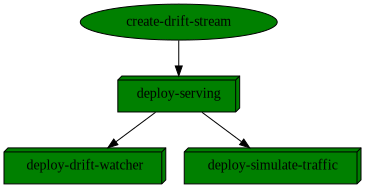

uid,start,state,name,parameters,results
...463132ad,Sep 15 21:56:24,completed,create-drift-stream,stream_path=pipelines/gitops-flow-v2/model-endpoints/log_stream,


In [27]:
run_id = project.run(
    name="deploy",
    arguments={"model_path": "store://models/gitops-flow-v2/model#0:latest"},
    dirty=True,
    watch=True
)

### Invoke Model

In [42]:
serving_fn = project.get_function("serving")
serving_fn.invoke(
    path='/v2/models/model/infer',
    body={
        "inputs" : [
            [0, 0, 1, 0, 50, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 120, 219, 1, 158, 1.6, 0.0],
            [0, 0, 1, 0, 44, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 130, 219, 0, 188, 0.0, 0.0],
            [0, 0, 0, 1, 70, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 130, 322, 0, 109, 2.4, 3.0]
        ]
    }
)

> 2023-09-15 22:10:30,393 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-v2-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': '9120f83a-c731-4f93-879b-05c00868e362',
 'model_name': 'model',
 'outputs': [1, 1, 0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [36]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = "model"

# Get test set
df = project.get_artifact("train_test_set").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop("target", axis=1).to_dict(orient="split")["data"]

,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,age,sex_male,sex_female,cp_typical_angina,cp_atypical_angina,cp_non_anginal_pain,...,thal_normal,thal_reversable_defect,thal_fixed_defect,trestbps,chol,restecg,thalach,oldpeak,ca,target
0,0,0,1,0,50,0,1,0,0,1,...,0,1,0,120,219,1,158,1.6,0.0,1
1,0,0,1,0,44,1,0,0,1,0,...,0,1,0,130,219,0,188,0.0,0.0,1
2,0,0,0,1,70,1,0,1,0,0,...,0,1,0,130,322,0,109,2.4,3.0,0
3,0,0,1,0,60,0,1,1,0,0,...,1,0,0,150,258,0,157,2.6,2.0,0
4,0,0,1,0,47,1,0,0,0,1,...,0,1,0,138,257,0,156,0.0,0.0,1


In [37]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/12000 [00:00<?, ?it/s]

## 4. Re-Training Flow via CI/CD

![](docs/gitops-flow.png)

### Simulate Drift Event

In [38]:
import json
import v3io.dataplane

In [39]:
v3io_client = v3io.dataplane.Client()

In [40]:
drift_event = {'endpoint_id': '340c863d748d4bf8e040281b75bc6eb04209fd23', 'drift_status': 'POSSIBLE_DRIFT', 'drift_measure': 0.87}

In [41]:
v3io_client.stream.put_records(
    container='users',
    stream_path=f"pipelines/{project.name}/model-endpoints/log_stream",
    records=[{'data': json.dumps(drift_event), 'shard_id': 0}]
)